In [4]:
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
#Import the Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#Import h2o grid search
import h2o.grid
from h2o.grid.grid_search import H2OGridSearch
from sklearn.model_selection import train_test_split

In [7]:
df_train_est_A = pd.read_csv("train_est_A.csv")
df_train_obs_A = pd.read_csv("train_obs_A.csv")

In [8]:
df_train_est_A=df_train_est_A.drop(columns = "Unnamed: 0")
df_train_obs_A=df_train_obs_A.drop(columns = "Unnamed: 0")


In [9]:
df_train = pd.concat([df_train_est_A,df_train_obs_A])
df_train

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
0,8.4,1.233,1425.1,0.0,0.0,1211.7,1.0,281.4,0.0,0.0,...,-38.467,0.0,284.7,100.0,29429.7,0.8,-0.4,0.7,-0.0,0.0
1,8.2,1.233,4068.2,0.0,0.0,2607.0,1.0,281.1,0.0,0.0,...,-39.609,0.0,284.6,100.0,6254.4,0.6,-0.1,0.6,-0.0,0.0
2,8.2,1.230,1978.0,0.0,0.0,1660.5,1.0,281.0,0.0,0.0,...,-39.013,0.1,283.7,100.0,3041.6,1.5,1.2,0.8,-0.0,0.0
3,8.1,1.229,1722.0,0.0,0.0,1699.3,1.0,280.9,0.0,0.0,...,-36.024,0.3,284.2,100.0,3572.6,1.5,0.8,1.2,-0.0,0.0
4,8.3,1.228,1456.4,0.0,0.0,1294.7,1.0,281.3,0.0,0.0,...,-31.374,0.2,284.6,100.0,2699.2,1.8,1.3,1.2,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29662,5.9,1.279,1291.5,0.0,0.0,1302.5,0.0,276.0,0.0,0.0,...,-27.830,0.0,278.4,59.4,41022.4,2.0,0.6,1.9,-0.0,0.0
29663,5.7,1.283,1824.1,0.0,0.0,1009.3,0.0,275.5,0.0,0.0,...,-32.546,0.0,278.0,23.8,38581.9,1.8,0.3,1.8,-0.0,0.0
29664,5.4,1.286,1824.1,0.0,0.0,149.5,0.0,274.7,0.0,0.0,...,-35.674,0.0,277.6,12.2,39697.7,1.5,0.1,1.5,-0.0,0.0
29665,5.3,1.289,1824.1,0.0,0.0,1137.7,0.0,274.4,0.0,0.0,...,-36.822,0.0,277.3,5.5,28090.1,1.3,-0.0,1.3,-0.0,0.0


In [10]:
# Calcola il primo e terzo quartile per ciascuna colonna
Q1 = df_train.quantile(0.25)
Q3 = df_train.quantile(0.75)

    # Calcola l'intervallo interquartile (IQR) per ciascuna colonna
IQR = Q3 - Q1

    # Definisci i limiti per identificare gli outlier per ciascuna colonna
limite_inferiore = Q1 - 3 * IQR
limite_superiore = Q3 + 3 * IQR

    # Sostituisci gli outlier con i valori più estremi tra i non-outlier per ciascuna colonna
for colonna in df_train.columns:
    df_train[colonna] = df_train[colonna].apply(lambda x: limite_inferiore[colonna] if x < limite_inferiore[colonna] else (limite_superiore[colonna] if x > limite_superiore[colonna] else x))

In [11]:
dimensione_test = 2160

# Calcola il numero di righe per il set di addestramento
dimensione_addestramento = len(df_train) - dimensione_test

In [12]:
train = df_train.iloc[:dimensione_addestramento]
test = df_train.iloc[dimensione_addestramento:]

In [13]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_train_v1 = scaler.fit_transform(train)
scaled_X_train = pd.DataFrame(scaled_X_train_v1,columns=train.columns,index=train.index)
scaled_X_test = scaler.fit_transform(test)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=test.columns,index=test.index)
scaled_X_test.shape

(2160, 46)

In [14]:
h2o.cluster().shutdown()

AttributeError: 'NoneType' object has no attribute 'shutdown'

In [16]:
h2o.init(    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=32  # in gigabytes
        )

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 20.0.1+9-29, mixed mode, sharing)
  Starting server from C:\Users\claxl\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\claxl\AppData\Local\Temp\tmpinbt9g79
  JVM stdout: C:\Users\claxl\AppData\Local\Temp\tmpinbt9g79\h2o_Claudio_started_from_python.out
  JVM stderr: C:\Users\claxl\AppData\Local\Temp\tmpinbt9g79\h2o_Claudio_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Rome
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_Claudio_odiflh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,31.98 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [17]:
features_name = [c for c in df_train.columns if c != 'pv_measurement']
target = 'pv_measurement'

In [18]:
h2o_train = h2o.H2OFrame(train)
h2o_test = h2o.H2OFrame(test)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
xgb = H2OXGBoostEstimator(seed=42, model_id='XGBoost', nfolds=5, keep_cross_validation_predictions = False)



In [20]:
%time
xgb.train(x=features_name, y=target, training_frame=h2o_train, validation_frame=h2o_test)


CPU times: total: 0 ns
Wall time: 0 ns


H2OResponseError: Server error water.exceptions.H2ONotFoundArgumentException:
  Error: POST /3/ModelBuilders/xgboost not found
  Request: POST /3/ModelBuilders/xgboost
    data: {'model_id': 'XGBoost', 'training_frame': 'Key_Frame__upload_ab0b50e2e8e62f7b389085e38fd54f67.hex', 'validation_frame': 'Key_Frame__upload_9352800358fae652a45eae1eb6274f6c.hex', 'nfolds': '5', 'keep_cross_validation_models': 'True', 'keep_cross_validation_predictions': 'False', 'keep_cross_validation_fold_assignment': 'False', 'score_each_iteration': 'False', 'fold_assignment': 'auto', 'response_column': 'pv_measurement', 'ignore_const_cols': 'True', 'stopping_rounds': '0', 'stopping_metric': 'auto', 'stopping_tolerance': '0.001', 'max_runtime_secs': '0.0', 'seed': '42', 'distribution': 'auto', 'tweedie_power': '1.5', 'categorical_encoding': 'auto', 'quiet_mode': 'True', 'ntrees': '50', 'max_depth': '6', 'min_rows': '1.0', 'min_child_weight': '1.0', 'learn_rate': '0.3', 'eta': '0.3', 'sample_rate': '1.0', 'subsample': '1.0', 'col_sample_rate': '1.0', 'colsample_bylevel': '1.0', 'col_sample_rate_per_tree': '1.0', 'colsample_bytree': '1.0', 'colsample_bynode': '1.0', 'max_abs_leafnode_pred': '0.0', 'max_delta_step': '0.0', 'score_tree_interval': '0', 'min_split_improvement': '0.0', 'gamma': '0.0', 'nthread': '-1', 'build_tree_one_node': 'False', 'parallelize_cross_validation': 'True', 'calibrate_model': 'False', 'calibration_method': 'auto', 'max_bins': '256', 'max_leaves': '0', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': '0.0', 'one_drop': 'False', 'skip_drop': '0.0', 'tree_method': 'auto', 'grow_policy': 'depthwise', 'booster': 'gbtree', 'reg_lambda': '1.0', 'reg_alpha': '0.0', 'dmatrix_type': 'auto', 'backend': 'auto', 'gainslift_bins': '-1', 'auc_type': 'auto', 'scale_pos_weight': '1.0', 'score_eval_metric_only': 'False'}


In [30]:
xgb


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost


Model Summary: 
    number_of_trees
--  -----------------
    50

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 44629.56846018314
RMSE: 211.2571145788542
MAE: 101.24741905212753
RMSLE: NaN
Mean Residual Deviance: 44629.56846018314

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 126944.7983495996
RMSE: 356.2931354230665
MAE: 184.0721906944523
RMSLE: NaN
Mean Residual Deviance: 126944.7983495996

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 92165.52123282614
RMSE: 303.587748818733
MAE: 141.77222029511594
RMSLE: NaN
Mean Residual Deviance: 92165.52123282614

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     141.769   3.23721     146.564       141.12        142.067       137.481       141.61
mean_residual_deviance  92156.9   2505.47     93744.4       89944.7       93456.6       89010.6       94628.2
mse                     92156.9   2505.47     93744.4       89944.7       93456.6       89010.6       94628.2
r2                      0.879951  0.00591892  0.878806      0.881571      0.872516      0.888755      0.878105
residual_deviance       92156.9   2505.47     93744.4       89944.7       93456.6       89010.6       94628.2
rmse                    303.551   4.13627     306.177       299.908       305.707       298.346       307.617
rmsle                   nan       0           nan           nan           nan           nan           nan

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2023-10-18 11:12:10  40.269 sec  0.0                1019.7623198652516  521.394289220114    1039915.1890169596   1176.906015361446   689.9296479319395   1385107.7689939563
     2023-10-18 11:12:11  40.613 sec  1.0                751.5816947781079   370.70494327109685  564875.0439255331    879.9213681330854   499.2261321225514   774261.6140972008
     2023-10-18 11:12:11  40.746 sec  2.0                573.6310070167051   277.37685416005326  329052.5322109991    679.8912534917447   374.677630719984    462252.11657457583
     2023-10-18 11:12:11  40.891 sec  3.0                457.45149972799214  222.10542430344185  209261.8746033892    548.1494414167524   299.2409350544076   300467.81012549775
     2023-10-18 11:12:11  41.060 sec  4.0                385.8221538473911   189.2839462851927   148858.73439943994   468.69666244458625  257.00534428485014  219676.5613866944
     2023-10-18 11:12:11  41.208 sec  5.0                341.5961342107187   168.96172701432448  116687.91890770732   418.76843618746136  229.88728538305946  175367.00314689192
     2023-10-18 11:12:11  41.420 sec  6.0                315.66151031638094  155.96241219266375  99642.18909521868    390.4550408997096   213.48707736370463  152455.1389639939
     2023-10-18 11:12:12  41.580 sec  7.0                299.1103943702579   146.77681790931484  89467.02802033121    375.4158519288892   203.4888081573088   140937.06187949367
     2023-10-18 11:12:12  41.735 sec  8.0                288.4175670397631   140.0431273717449   83184.69297713626    364.29792092282344  195.02964204175882  132712.97518869172
     2023-10-18 11:12:12  41.925 sec  9.0                281.6103696282374   135.3435670848115   79304.40028215248    359.1200754169797   190.231674348356    128967.22856749721
---  ---                  ---         ---                ---                 ---                 ---    

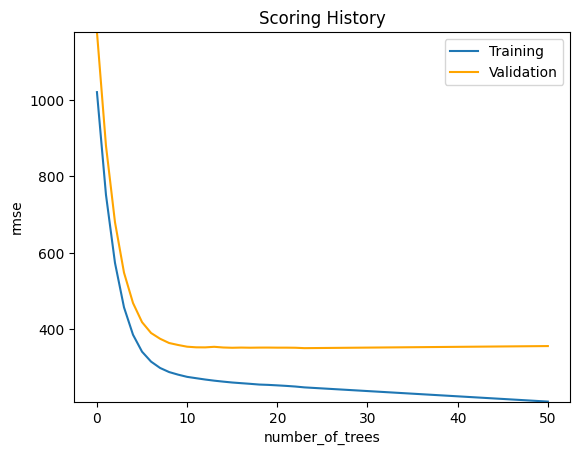

In [31]:
xgb.plot()


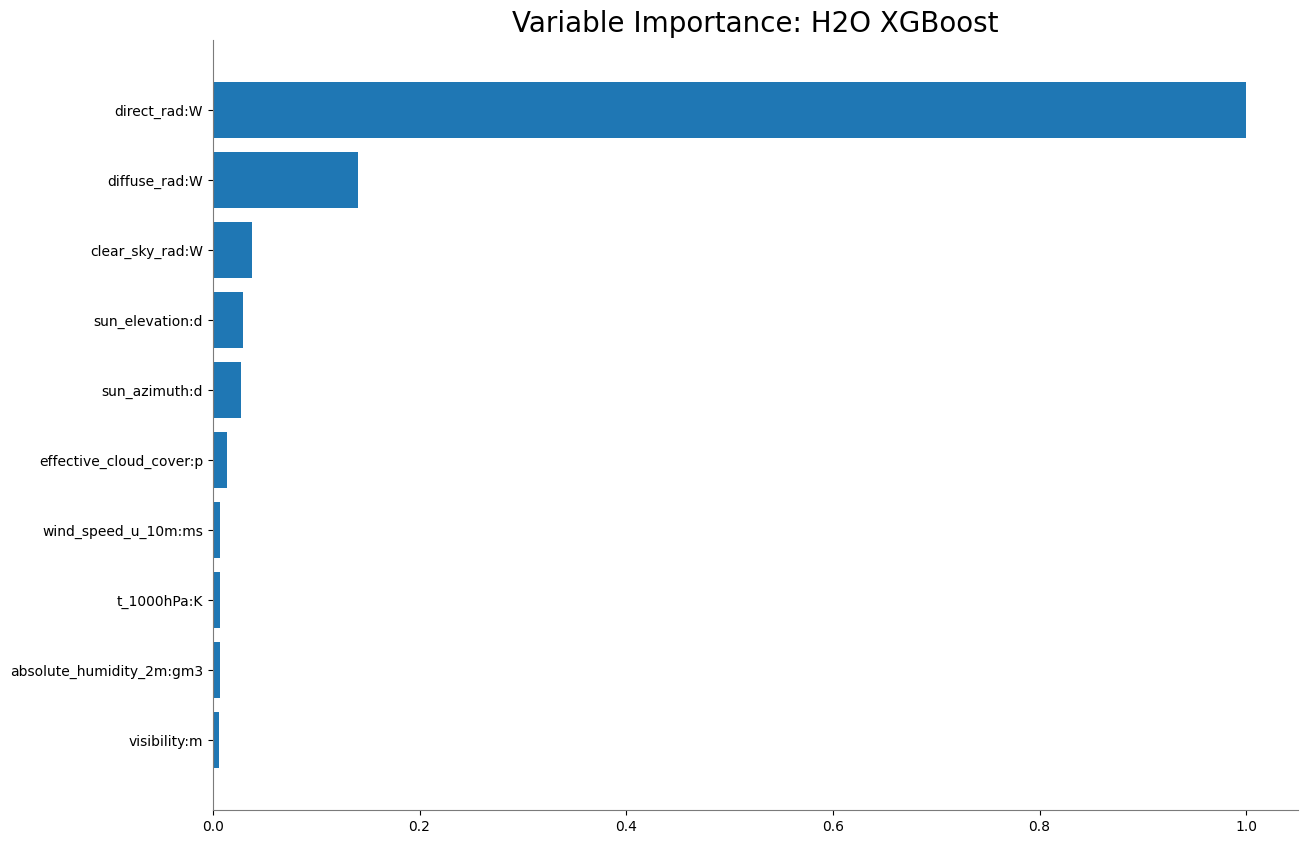

<Figure size 640x480 with 0 Axes>

In [32]:
xgb.varimp_plot()


In [36]:
xgb_def_pred = xgb.predict(h2o_test)
xgb_def_pred.cbind(h2o_test[target])


xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


predict,pv_measurement
0.0667453,0
42.0399,5.28
198.948,65.56
355.818,271.92
1044.12,618.42
1849.88,2134.88
1979.03,2609.2
2645,2712.16
2657.36,2712.16
2596.11,2712.16


In [38]:
default_xgb_per = xgb.model_performance(h2o_test)
default_xgb_per

ModelMetricsRegression: xgboost
** Reported on test data. **

MSE: 126944.7983495996
RMSE: 356.2931354230665
MAE: 184.0721906944523
RMSLE: NaN
Mean Residual Deviance: 126944.7983495996

In [21]:
dl = H2ODeepLearningEstimator(seed=42, model_id='DL',
                              nfolds= 5,
                              keep_cross_validation_predictions = False
                              )
%time
dl.train(x=features_name, y=target, training_frame=h2o_train, validation_frame=h2o_test)

CPU times: total: 0 ns
Wall time: 0 ns
deeplearning Model Build progress: |

C:\Users\claxl\anaconda3\Lib\site-packages\h2o\estimators\estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [precip_type_5min:idx, snow_depth:cm, fresh_snow_1h:cm, rain_water:kgm2, fresh_snow_3h:cm, fresh_snow_24h:cm, dew_or_rime:idx, precip_5min:mm, fresh_snow_6h:cm, wind_speed_w_1000hPa:ms, snow_drift:idx, snow_melt_10min:mm, fresh_snow_12h:cm, prob_rime:p, elevation:m, snow_density:kgm3]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DL


Status of Neuron Layers: predicting pv_measurement, regression, gaussian distribution, Quadratic loss, 46.401 weights/biases, 557,8 KB, 364.825 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        29       Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.03018668261882528    0.027518048882484436   0.0         -0.004545272789499873  0.1451786756515503   0.41738353489960134  0.07118165493011475
    3        200      Rectifier  0.0        0.0   0.0   0.08774854965697741    0.09302675724029541    0.0         -0.03753460715468611   0.09432870149612427  0.798891028152982    0.09826534986495972
    4        1        Linear                0.0   0.0   0.0013464623274194309  0.0005426411516964436  0.0         0.0031731753150234     0.08199197053909302  0.6064202013210326   1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 88422.82432421077
RMSE: 297.35975572395597
MAE: 159.02890180695852
RMSLE: NaN
Mean Residual Deviance: 88422.82432421077

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 139476.2218544647
RMSE: 373.4651548062613
MAE: 208.29766510271497
RMSLE: NaN
Mean Residual Deviance: 139476.2218544647

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 104892.20296254882
RMSE: 323.87065776718464
MAE: 165.92458872991804
RMSLE: NaN
Mean Residual Deviance: 104892.20296254882

Cross-Validation Metrics Summary: 
                        mean     sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     165.956  7.36191    173.208       174.633       160.875       159.073       161.991
mean_residual_deviance  104883   1937.51    106392        103933        107482        103512        103094
mse                     104883   1937.51    106392        103933        107482        103512        103094
r2                      0.86378  0.0049032  0.865972      0.862804      0.855654      0.866735      0.867736
residual_deviance       104883   1937.51    106392        103933        107482        103512        103094
rmse                    323.845  2.98584    326.178       322.387       327.845       321.732       321.082
rmsle                   nan      0          nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-10-20 00:46:16  0.000 sec                           0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-10-20 00:46:18  1 min  1.368 sec  16241 obs/sec     1.03298   1             32953      336.945          113532               180.929         0.851991       401.061            160850                 226.655           0.823548
    2023-10-20 00:46:23  1 min  6.795 sec  22760 obs/sec     5.18774   5             165494     316.384          100099               1

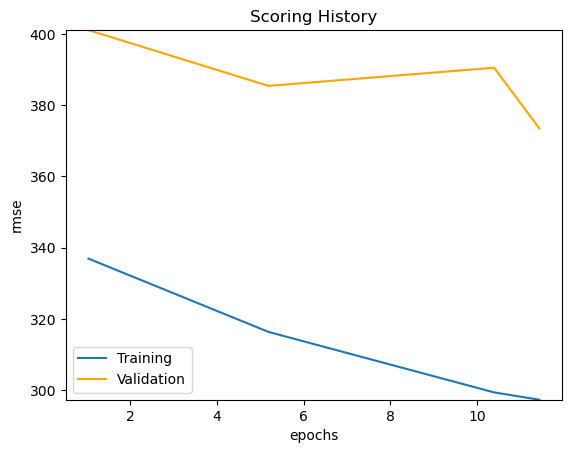

In [22]:
dl.plot()

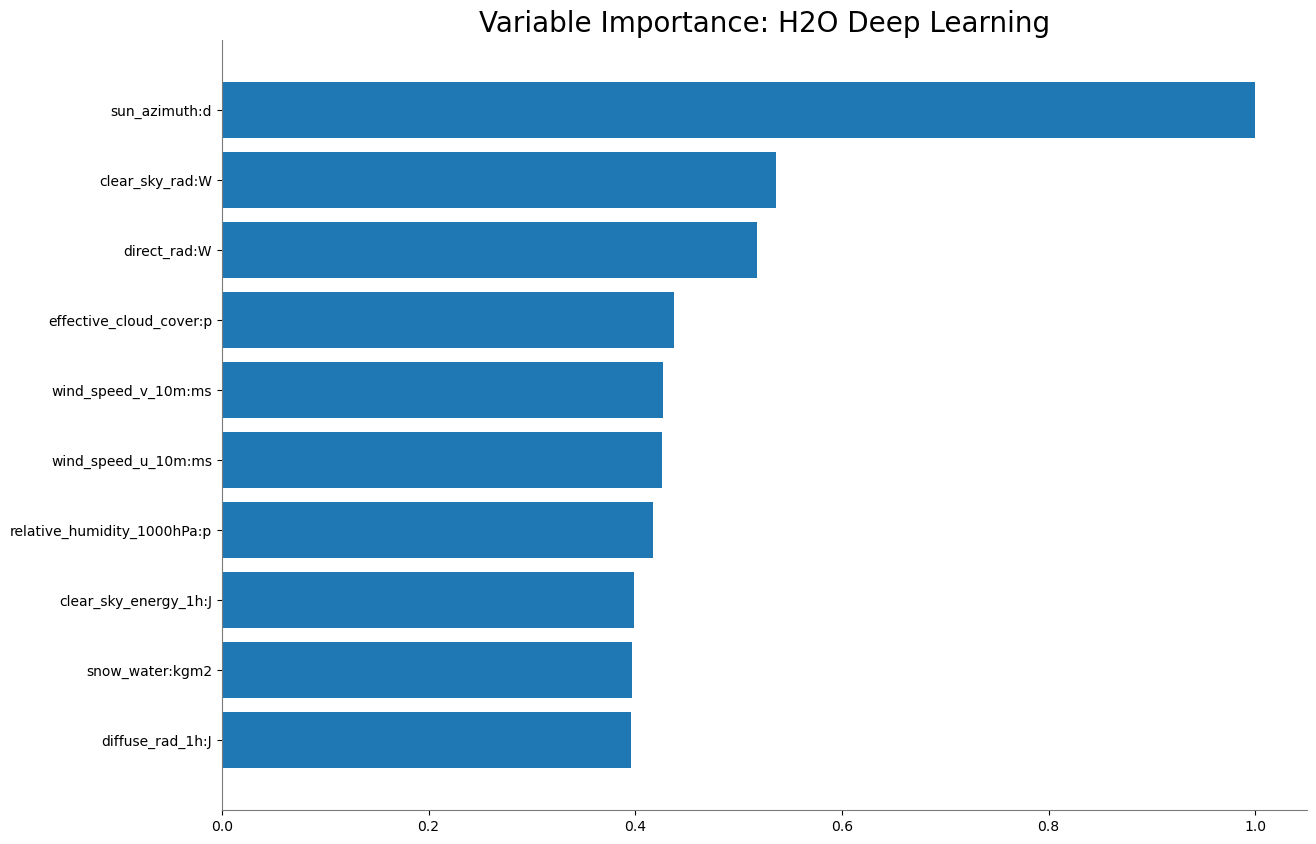

<Figure size 640x480 with 0 Axes>

In [23]:
dl.varimp_plot()

In [24]:
default_dl_per = dl.model_performance(h2o_test)
default_dl_per

ModelMetricsRegression: deeplearning
** Reported on test data. **

MSE: 139476.2218544647
RMSE: 373.4651548062613
MAE: 208.29766510271497
RMSLE: NaN
Mean Residual Deviance: 139476.2218544647

In [32]:
x  = features_name
y = target
train = h2o_train
valid = h2o_test

In [28]:
dl = H2ODeepLearningEstimator(seed=623, model_id='DL',
                              nfolds= 0,
                              keep_cross_validation_predictions = False,
                              stopping_metric='MAE',
                              epochs=10
                              )

hyper_params = {'hidden' : [[165], [330], [495], [100], [200], 
                            [165, 33], [165, 165], [200, 165], [330, 330], 
                            [165, 330, 165]]             
               }

search_criteria_tune = {'strategy': "Cartesian",
                       }

dl_grid = H2OGridSearch(model=dl, 
                        hyper_params=hyper_params,
                         grid_id = 'hidden_layer_grid',
                         search_criteria=search_criteria_tune
                         )

In [29]:
%time 
dl_grid.train(x=features_name, y=target, training_frame=h2o_train, validation_frame=h2o_test) 

CPU times: total: 0 ns
Wall time: 0 ns
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,hidden,model_ids,residual_deviance
,330,hidden_layer_grid_model_8,127290.8454995
,200,hidden_layer_grid_model_5,128039.5711934
,165,hidden_layer_grid_model_7,137734.3051202
,"[330, 330]",hidden_layer_grid_model_15,138090.9907192
,495,hidden_layer_grid_model_3,138959.7528474
,"[165, 330, 165]",hidden_layer_grid_model_16,140745.5770729
,"[200, 165]",hidden_layer_grid_model_14,142320.5406074
,165,hidden_layer_grid_model_1,163295.4240551
,330,hidden_layer_grid_model_2,182658.1818194
,200,hidden_layer_grid_model_11,189361.0884990


In [33]:
hidden_per = dl_grid.get_grid(sort_by='mae', decreasing=False)
hidden_per.sorted_metric_table()

,,hidden,model_ids,mae
0,,"[165, 330, 165]",hidden_layer_grid_model_16,215.932499
1,,"[330, 330]",hidden_layer_grid_model_15,216.820588
2,,330,hidden_layer_grid_model_8,217.964044
3,,200,hidden_layer_grid_model_5,225.065222
4,,495,hidden_layer_grid_model_3,226.508905
5,,165,hidden_layer_grid_model_7,231.416531
6,,"[200, 165]",hidden_layer_grid_model_14,258.038428
7,,495,hidden_layer_grid_model_9,280.306436
8,,165,hidden_layer_grid_model_1,282.208868
9,,200,hidden_layer_grid_model_11,287.487387


In [34]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],
    seed=42,
    model_id='DL',
    activation='rectifier_with_dropout'
    )

hyper_params = {'hidden_dropout_ratios' : [[0], [0.01], [0.1], [0.15], [0.25], [0.3], [0.2],
                                           [0.35],[0.5], [0.6], [0.8]]
                                            
    }

search_criteria_tune = {'strategy': "Cartesian"
                }

dl_grid = H2OGridSearch(model=dl, 
                         hyper_params=hyper_params,
                         grid_id = 'dropout_grid',
                         search_criteria=search_criteria_tune,
                         )

In [35]:
%time 
dl_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

CPU times: total: 0 ns
Wall time: 0 ns
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,hidden_dropout_ratios,model_ids,residual_deviance
,0.25,dropout_grid_model_5,135263.4116303
,0.3,dropout_grid_model_6,140381.9210482
,0.8,dropout_grid_model_11,140953.8524525
,0.0,dropout_grid_model_1,143432.1235394
,0.15,dropout_grid_model_4,150969.6763386
,0.2,dropout_grid_model_7,164096.9747569
,0.1,dropout_grid_model_3,165162.4337546
,0.5,dropout_grid_model_9,168947.1292571
,0.35,dropout_grid_model_8,170275.7785176
,0.01,dropout_grid_model_2,297543.5221978


In [36]:
dropout = dl_grid.get_grid(sort_by='mae', decreasing=False)
dropout.sorted_metric_table()

,,hidden_dropout_ratios,model_ids,mae
0,,0.25,dropout_grid_model_5,209.950674
1,,0.3,dropout_grid_model_6,219.230063
2,,0.8,dropout_grid_model_11,224.836301
3,,0.15,dropout_grid_model_4,226.115534
4,,0.35,dropout_grid_model_8,238.544273
5,,0.2,dropout_grid_model_7,258.244110
6,,0.5,dropout_grid_model_9,261.493939
7,,0.1,dropout_grid_model_3,264.422641
8,,0.0,dropout_grid_model_1,272.120835
9,,0.6,dropout_grid_model_10,321.766313


In [37]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],
    seed=42,
    model_id='DL',
    activation = 'rectifier_with_dropout',
    hidden_dropout_ratios=[0.3],
    distribution='auto',
    adaptive_rate=False
    )

hyper_params = { 'rate' : [0.0001, 0.0005, 0.0008, 0.001, 0.0015, 0.0020, 0.003, 0.004, 0.007, 0.009]
                
    }

search_criteria_tune = {'strategy': "Cartesian",
                       }

dl_grid = H2OGridSearch(model=dl, hyper_params=hyper_params,
                         grid_id = 'rate_grid',
                         search_criteria=search_criteria_tune,
                         )

In [38]:
%time 
dl_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

CPU times: total: 0 ns
Wall time: 0 ns
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,rate,model_ids,residual_deviance
,0.004,rate_grid_model_8,142347.5403502
,0.0008,rate_grid_model_3,154568.3101634
,0.003,rate_grid_model_7,158462.0795226
,0.007,rate_grid_model_9,163943.4662733
,0.009,rate_grid_model_10,165326.5819910
,0.0015,rate_grid_model_5,170667.8374735
,0.0001,rate_grid_model_1,179200.1630896
,0.0005,rate_grid_model_2,184075.3877185
,0.002,rate_grid_model_6,205566.4885269
,0.001,rate_grid_model_4,732365.9201030


In [39]:
learn_per = dl_grid.get_grid(sort_by='mae', decreasing=False)
learn_per.sorted_metric_table()

,,rate,model_ids,mae
0,,0.0040,rate_grid_model_8,214.878654
1,,0.0030,rate_grid_model_7,227.129361
2,,0.0090,rate_grid_model_10,250.042592
3,,0.0015,rate_grid_model_5,254.668257
4,,0.0070,rate_grid_model_9,263.158159
5,,0.0008,rate_grid_model_3,273.579323
6,,0.0001,rate_grid_model_1,279.646833
7,,0.0005,rate_grid_model_2,317.743309
8,,0.0020,rate_grid_model_6,321.923350
9,,0.0010,rate_grid_model_4,513.780317


In [40]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],
    seed=42,
    model_id='DL',
    activation = 'rectifier_with_dropout',
    hidden_dropout_ratios=[0.3],
    distribution='auto',
    adaptive_rate=False,
    l2=1e-5,
    rate=0.0015
    )

hyper_params = { 'rate_annealing' : [1e-6, 1e-7, 1e-8, 1e-5],
                'rate_decay': [1, 0.8, 0.9, 1.1, 1.2],
                'momentum_ramp' : [10000, 15000, 5000, 20000, 50000, 100000],
                'momentum_stable' : [0.9, 0.95, 0.99, 0.999],
                'momentum_start' : [0.9, 0.4, 0.5, 0.7, 0.8]
    }

search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 600, #10 min  
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 42 
                       }

dl_grid = H2OGridSearch(model=dl, 
                        hyper_params=hyper_params,
                        grid_id = 'rate_random_grid',
                        search_criteria=search_criteria_tune,
                         )

In [41]:
%time 
dl_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

CPU times: total: 0 ns
Wall time: 0 ns
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%


,momentum_ramp,momentum_stable,momentum_start,rate_annealing,rate_decay,model_ids,residual_deviance
,100000.0,0.95,0.9,1e-06,0.8,rate_random_grid_model_72,130868.5802399
,100000.0,0.999,0.4,1e-08,1.2,rate_random_grid_model_29,131999.3587928
,20000.0,0.99,0.8,1e-06,0.8,rate_random_grid_model_91,134018.1598365
,10000.0,0.999,0.9,1e-06,1.1,rate_random_grid_model_10,134175.1898774
,15000.0,0.95,0.7,1e-06,1.1,rate_random_grid_model_84,134269.1115082
,20000.0,0.95,0.7,1e-06,0.9,rate_random_grid_model_61,136624.9068786
,100000.0,0.999,0.4,1e-07,1.0,rate_random_grid_model_100,137009.6678705
,10000.0,0.9,0.8,1e-06,0.9,rate_random_grid_model_58,137304.8637550
,50000.0,0.95,0.9,1e-07,0.9,rate_random_grid_model_7,137369.1906085
,15000.0,0.99,0.5,1e-06,0.9,rate_random_grid_model_71,138034.9283659


In [42]:
learn_per = dl_grid.get_grid(sort_by='mae', decreasing=False)
learn_per.sorted_metric_table()

,,momentum_ramp,momentum_stable,momentum_start,rate_annealing,rate_decay,model_ids,mae
0,,100000.0,0.950,0.9,1.000000e-06,0.8,rate_random_grid_model_72,206.953539
1,,20000.0,0.990,0.8,1.000000e-06,0.8,rate_random_grid_model_91,207.355895
2,,100000.0,0.999,0.4,1.000000e-08,1.2,rate_random_grid_model_29,207.881968
3,,50000.0,0.950,0.9,1.000000e-07,0.9,rate_random_grid_model_7,210.864725
4,,10000.0,0.999,0.9,1.000000e-06,1.1,rate_random_grid_model_10,212.957284
...,...,...,...,...,...,...,...,...
95,,10000.0,0.999,0.7,1.000000e-05,1.0,rate_random_grid_model_57,358.410147
96,,15000.0,0.990,0.4,1.000000e-05,0.8,rate_random_grid_model_32,389.667105
97,,10000.0,0.950,0.5,1.000000e-06,0.9,rate_random_grid_model_76,411.555323
98,,5000.0,0.999,0.8,1.000000e-08,1.2,rate_random_grid_model_14,505.198033


In [57]:
best_dl_model = dl_grid.models[0]

dl_checkpoint = H2ODeepLearningEstimator(checkpoint=best_dl_model.model_id,
    epochs=200,
    hidden=[165],
    seed=42,
    model_id='DL_checkpoint',
    activation = 'rectifier_with_dropout',
    hidden_dropout_ratios=[0.3],
    distribution='auto',
    adaptive_rate=False,
    l2=1e-5,
    rate=0.0015,
    momentum_ramp=100000.0,
    momentum_stable=0.95,
    momentum_start=0.9,
    rate_annealing=1.0e-6,
    rate_decay=0.8,
    reproducible=True,                                     
                                         
    stopping_metric='MAE',
    stopping_tolerance=0.0005,
    stopping_rounds=5
    )

In [58]:
%time 
dl_checkpoint.train(x=x, y=y, training_frame=train, validation_frame=valid)

CPU times: total: 0 ns
Wall time: 0 ns
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DL_checkpoint


Status of Neuron Layers: predicting pv_measurement, regression, gaussian distribution, Quadratic loss, 5.116 weights/biases, 48,7 KB, 638.020 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2     mean_rate              rate_rms    momentum    mean_weight             weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  -----  ---------------------  ----------  ----------  ----------------------  -------------------  -------------------  -----------------------
    1        29       Input             0.0
    2        165      RectifierDropout  30.0       0.0   1e-05  0.0009157397435046732  0.0         0.95        -0.0013191968725988512  0.10097771883010864  0.2848188515309773   0.1692953109741211
    3        1        Linear                       0.0   1e-05  0.0007325917831622064  0.0         0.95        0.008707925841162884    0.0513218492269516   0.15845355386849033  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 115921.6193402537
RMSE: 340.4726411038833
MAE: 177.70125417011332
RMSLE: NaN
Mean Residual Deviance: 115921.6193402537

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 133570.90187019488
RMSE: 365.47353101174764
MAE: 202.69670347454212
RMSLE: NaN
Mean Residual Deviance: 133570.90187019488

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-10-20 01:00:27  0.000 sec                           0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-10-20 01:00:27  3 min 39.344 sec  103574 obs/sec    1         1             31901      379.717          144185               227.979         0.81203        402.343            161880                 259.914           0.822419
    2023-10-20 01:00:30  3 min 42.130 sec  104081 obs/sec    10        10            319010     359.417          129180               194.441         0.831591       361.758            130869                 206.954           0.856438
    2023-10-20 01:03:40  3 min 43.536 sec  80967 obs/sec     11        11            350911     343.713          118139               181.627         0.845985       397.994            158399                 224.656           0.826238
    2023-10-20 01:03:42  3 min 44.832 sec  68764 obs/sec     12        12            382812     341.044          116311               178.38          0.848369       389.598            151787                 219.756           0.833491
    2023-10-20 01:03:43  3 min 46.146 sec  60870 obs/sec     13        13            414713     339.731          115417               179.549         0.849533       381.891            145841                 215.414           0.840013
    2023-10-20 01:03:44  3 min 47.433 sec  55632 obs/sec     14        14            446614     338.088          114304               177.118         0.850985       374.386            140165                 211.226           0.84624
    2023-10-20 01:03:45  3 min 48.769 sec  51519 obs/sec     15        15            478515     340.473          115922               177.701         0.848876       365.474            133571                 202.697           0.853474
    2023-10-20 01:03:47  3 min 50.156 sec  48120 obs/sec     16        16            510416     342.816          117523               185.8

In [59]:
tuned_dl_per = dl_checkpoint.model_performance(valid)

In [60]:
print("Default DL Model MAE: %.4f \nTuned DL Model MAE:%.4f" % (default_dl_per.mae(), tuned_dl_per.mae()))


Default DL Model MAE: 208.2977 
Tuned DL Model MAE:202.6967
